In [8]:
import sys
sys.path.append( '../utilities' )
from data_engine import DataEngine
from backtesting import Backtesting
import pandas as pd
import ta
import ccxt
import pandas_ta as pda

In [9]:
# pairList = pairJson['hitbtc2018']
pair = 'LUNA/USDT'
timeframe = '1h'
startDate = '2017-01-01T00:00:00'

dataEngine = DataEngine(session=ccxt.binance(), path_to_data='./database/')

df = dataEngine.get_historical_from_db(pair, timeframe, startDate)

Successfully load 14032 candles for LUNAUSDT


In [10]:
# -- Indicator variable --
trixLength = 9
trixSignal = 19
stochWindow = 14

# -- Drop all columns we do not need --
df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

# -- Indicators, you can edit every value --
df['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=df['close'], window=trixLength), window=trixLength), window=trixLength)
df['TRIX_PCT'] = df["TRIX"].pct_change()*100
df['TRIX_SIGNAL'] = ta.trend.sma_indicator(df['TRIX_PCT'], trixSignal)
df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=14, smooth1=3, smooth2=3)

df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=stochWindow)

print("Indicators loaded 100%")
df

Indicators loaded 100%


,open,high,low,close,volume,TRIX,TRIX_PCT,TRIX_SIGNAL,TRIX_HISTO,STOCH_RSI
timestamp,,,,,,,,,,
2020-08-21 10:00:00,0.5397,0.5397,0.4010,0.4584,1000167.44,NaN,NaN,NaN,NaN,NaN
2020-08-21 11:00:00,0.4588,0.4605,0.4500,0.4500,109805.56,NaN,NaN,NaN,NaN,NaN
2020-08-21 12:00:00,0.4494,0.4527,0.4258,0.4520,234247.81,NaN,NaN,NaN,NaN,NaN
2020-08-21 13:00:00,0.4519,0.4527,0.4459,0.4483,157480.31,NaN,NaN,NaN,NaN,NaN
2020-08-21 14:00:00,0.4485,0.4487,0.4300,0.4387,219494.92,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-03-29 15:00:00,107.3900,107.8900,105.0600,105.8800,374545.06,101.666454,0.314441,0.349018,-0.034577,0.326899
2022-03-29 16:00:00,105.8700,107.4900,103.8000,106.7400,474281.70,101.996743,0.324875,0.347451,-0.022576,0.490773
2022-03-29 17:00:00,106.7300,106.8600,104.8900,106.7000,210929.56,102.336253,0.332863,0.346779,-0.013916,0.474000


In [11]:
# -- Intern parameter --
dfTest = df[:]
#ndfTest = df[:]
startingBalance = 1000
makerFee = 0.0002
takerFee = 0.0007

# -- Rules --
StopLossActivation = False
takeProfitActivation = False
timeLimitActivation = False
showLog = False
waitNextSignal = False

# -- Hyper parameters --
stochOverBought = 0.85
stochOverSold = 0.25
SlPct = 0.02
TpPct = 0.02
timeLimit = 17


# -- Trade Functions --
# -- Condition to BUY market --

def buyCondition(row, previousRow):
    if row['TRIX_HISTO'] > 0 and row['STOCH_RSI'] < stochOverBought:
        return True
    else:
        return False

def sellCondition(row, previousRow):
    if row['TRIX_HISTO'] < 0:
        return True
    else:
        return False


# -- Value initialisation --
usd = startingBalance
wallet = startingBalance
coin = 0
lastAth = 0
previousRow = dfTest.iloc[0]
stopLoss = 0
takeProfit = 500000
buyReady = True
sellReady = True
currentTimeOpen = 0
timeSince = 0

# -- Definition of dfTrades, that will be the dataset to do your trades analyses --
dfTrades = None
dfTrades = pd.DataFrame(columns=['date', 'position', 'reason',
                                 'price', 'frais', 'fiat', 'coins', 'wallet', 'timeSince'])

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():
    timeSince += 1
    if currentTimeOpen > 0:
        currentTimeOpen += 1
    # -- Buy market order --
    if buyCondition(row, previousRow) and usd > 0 and buyReady == True:
        # -- You can define here at what price you buy --
        buyPrice = row['close']

        # -- Define the price of you SL and TP or comment it if you don't want a SL or TP --
        if StopLossActivation:
            stopLoss = buyPrice - SlPct * buyPrice
        if takeProfitActivation:
            takeProfit = buyPrice + TpPct * buyPrice
        if timeLimitActivation:
            currentTimeOpen = 1

        fee = takerFee * usd
        usd = usd - fee
        coin = usd / buyPrice
        usd = 0
        wallet = coin * row['close']

        if showLog:
            print("Buy COIN at", buyPrice, '$ the', index)

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Buy",
            'reason': 'Buy Market Order',
            'price': buyPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0

    # -- Take Profit --
    elif row['high'] > takeProfit and coin > 0:
        sellPrice = takeProfit
        usd = coin * sellPrice
        fee = makerFee * usd
        usd = usd - fee
        coin = 0
        wallet = usd

        if waitNextSignal:
            buyReady = False

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at Take Profit", sellPrice, '$ the', index)

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Take Profit',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0
    # -- Stop Loss --
    elif row['low'] < stopLoss and coin > 0:
        sellPrice = stopLoss
        usd = coin * sellPrice
        fee = makerFee * usd
        usd = usd - fee
        coin = 0
        wallet = usd

        currentTimeOpen = 0

        if waitNextSignal:
            buyReady = False

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at Stop Loss", sellPrice, '$ the', index)
        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Stop Loss',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0

    # -- Sell Market Order --
    elif sellCondition(row, previousRow):
        buyReady = True
        if coin > 0:
            # -- You can define here at what price you buy --
            sellPrice = row['close']
            usd = coin * sellPrice
            fee = takerFee * usd
            usd = usd - fee
            coin = 0
            # buyReady = True
            wallet = usd

            # -- You can uncomment the line below if you want to see logs --
            if showLog:
                print("Sell COIN at", sellPrice, '$ the', index)

            # -- Add the trade to DfTrades to analyse it later --
            myrow = {
                'date': index,
                'position': "Sell",
                'reason': 'Sell Market Order',
                'price': sellPrice,
                'frais': fee,
                'fiat': usd,
                'coins': coin,
                'wallet': wallet,
                'timeSince': timeSince
            }
            dfTrades = dfTrades.append(myrow, ignore_index=True)
            timeSince = 0

    elif currentTimeOpen > timeLimit and coin > 0:
        sellPrice = row['close']
        usd = coin * sellPrice
        fee = takerFee * usd
        usd = usd - fee
        coin = 0
        if waitNextSignal:
            buyReady = False
        wallet = usd

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at", sellPrice, '$ the', index)

        # -- Add the trade to DfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Time Market Order',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0
    previousRow = row

print("Final wallet", wallet)
print(dfTrades)


Final wallet 4771.412135011874
                   date position             reason     price     frais  \
0   2020-08-23 23:00:00      Buy   Buy Market Order    0.4821  0.700000   
1   2020-08-24 12:00:00     Sell  Sell Market Order    0.4911  0.712569   
2   2020-08-25 00:00:00      Buy   Buy Market Order    0.5232  0.712070   
3   2020-08-25 07:00:00     Sell  Sell Market Order    0.4858  0.660706   
4   2020-08-26 08:00:00      Buy   Buy Market Order    0.4707  0.660244   
..                  ...      ...                ...       ...       ...   
811 2022-03-27 09:00:00     Sell  Sell Market Order   90.5700  3.164938   
812 2022-03-28 01:00:00      Buy   Buy Market Order   93.3900  3.162723   
813 2022-03-28 14:00:00     Sell  Sell Market Order   95.9400  3.246806   
814 2022-03-28 19:00:00      Buy   Buy Market Order  100.1200  3.244533   
815 2022-03-29 12:00:00     Sell  Sell Market Order  103.2100  3.342328   

            fiat        coins       wallet timeSince  
0            

In [12]:
BTobject = Backtesting()
newDf = BTobject.simple_spot_backtest_analys(dfTrades=dfTrades, dfTest=dfTest, pairSymbol=pair, timeframe=timeframe)

Pair Symbol : LUNA/USDT | Timeframe : 1h
Period : [2020-08-21 10:00:00] -> [2022-03-29 19:00:00]
Starting balance : 999.3000000000001 $

----- General Informations -----
Final balance : 4771.41 $
Performance vs US Dollar : 377.48 %
Buy and Hold Performence : 23741.62 %
Performance vs Buy and Hold : -98.0 %
Best trade : +78.47 %, the 2021-02-09 05:00:00
Worst trade : -18.28 %, the 2021-05-23 05:00:00
Worst drawDown : - 59.31 %
Total fees :  1171.37 $

----- Trades Informations -----
Total trades on period : 408
Number of positive trades : 167
Number of negative trades :  241
Trades win rate ratio : 40.93 %
Average trades performance : 0.73 %
Average positive trades : 6.67 %
Average negative trades : -3.39 %

----- Time Informations -----
Average time duration for a trade : 14.92 periods
Maximum time duration for a trade : 44 periods
Minimum time duration for a trade : 1 periods
Average time duration between two trades : 19.46 periods
Maximum time duration between two trades : 62 periods

----- 2020 Performances: -39.79% -----


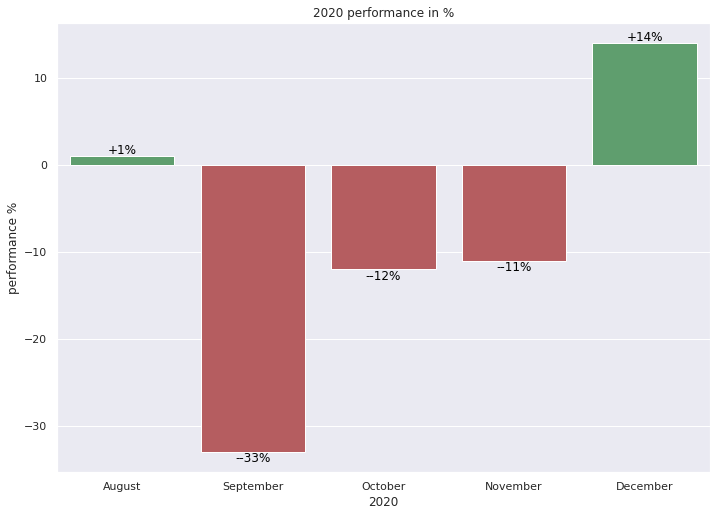

----- 2021 Performances: 455.92% -----


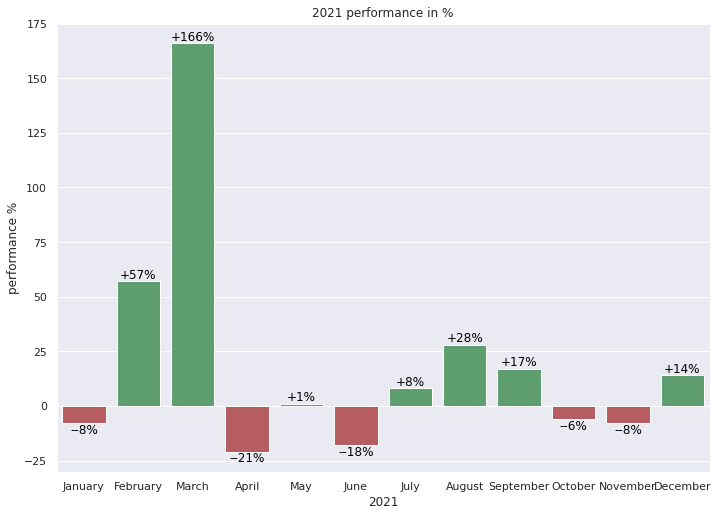

----- 2022 Performances: 42.84% -----


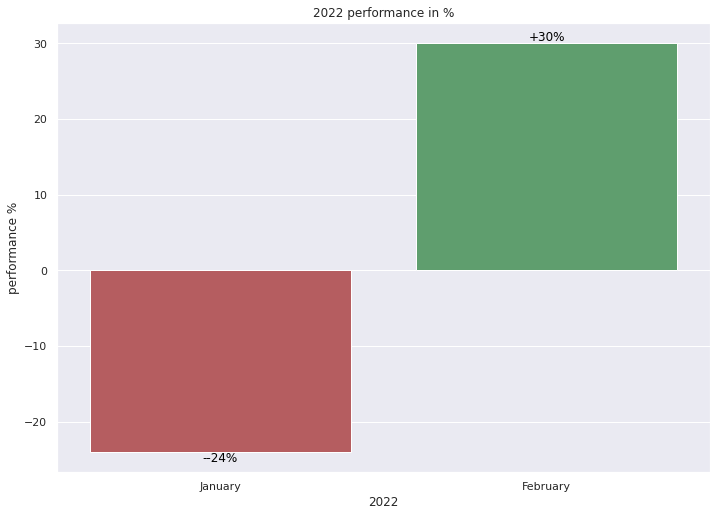

In [13]:
BTobject.plot_bar_by_month(dfTrades=dfTrades)


----- Plot -----


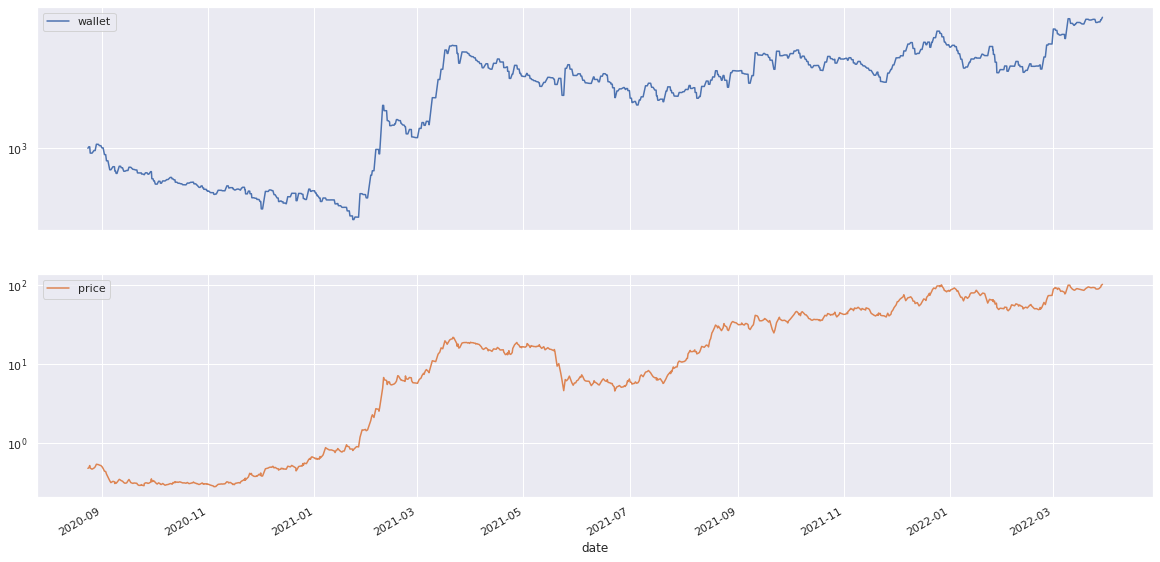

In [14]:
BTobject.plot_wallet_vs_price(dfTrades=dfTrades)